In [1]:
# Standard Imports
import os
import tensorflow
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from numpy import mean
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

# Silence tensforflow for the time being
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set seed
np.random.seed(0)
tensorflow.random.set_seed(0)

In [2]:
"""
Construct input PDF replicas
"""

from ganpdfs.pdformat import XNodes
from ganpdfs.pdformat import InputPDFs

# Define Parameters
nf = 3
q_value = 1.7
pdf_name = "PN3_GLOBAL_NNPDF31_nnlo_as_0118_070219-001"
# pdf_name = "NNPDF31_nlo_as_0118"

# Compute PDF replicas grid
xgrid = XNodes().build_xgrid()
inp_pdf = InputPDFs(pdf_name, xgrid, q_value, nf).build_pdf()
pdf = inp_pdf.reshape((inp_pdf.shape[0], inp_pdf.shape[1], inp_pdf.shape[2]))

nfl = pdf.shape[1]
nxg = pdf.shape[2]
print(pdf.shape)

(81, 7, 70)

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import multiply
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint

In [4]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Input PDF Layer
class add_pdf(Layer):
    
    def __init__(self, pdf, trainable=True, **kwargs):
        i = np.random.randint(50)
        self.pdf = K.constant(pdf[i])
        self.trainable = trainable
        super(add_pdf, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (None, self.pdf.shape[0], self.pdf.shape[1])

    def call(self, model_input):
        res = model_input * self.pdf
        return res

In [5]:
# define the standalone critic model
def define_critic(in_shape=(nfl, nxg), size_ext=512):
    # weight constraint
    const = ClipConstraint(1)
    # define model
    model = Sequential()
    # 1st Layer
    model.add(Dense(size_ext, kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # 2nd Layer
    model.add(Dense(size_ext // 2, kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1))
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, size_ext=128):
    # define model
    model = Sequential()
    n_nodes = 256 * 7 * 7
    # Define input
    g_input = Input(shape=latent_dim)
    g1l = Dense(n_nodes)(g_input)
    g1a = LeakyReLU(alpha=0.2)(g1l)
    # 2nd Layer
    g2l = Dense(size_ext)(g1a)
    g2b = BatchNormalization()(g2l)
    g2a = LeakyReLU(alpha=0.2)(g2b)
    # 3rd Layer
    g3l = Dense(size_ext * 2)(g2a)
    g3b = BatchNormalization()(g3l)
    g3a = LeakyReLU(alpha=0.2)(g3b)
    # output
    g4l = Dense(nfl * nxg)(g3a)
    g4r = Reshape((nfl, nxg))(g4l)
    g_output = add_pdf(pdf)(g4r)
    return Model(g_input, g_output, name="generator")

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

In [7]:
def plot_generated_pdf(true_pdf, g_model, nth_epochs, latent_dim, nb_output):
    """This method plots the comparison of the true
    and generated PDF replicas at each iterations for
    given flavours.
    """

    # Generate random vector and use it to make a prediction
    # for the Generator after a given training
    generated_pdf, _ = generate_fake_samples(g_model, latent_dim, nb_output)

    # Initialize the figure as a 4x4 grid
    fig = plt.figure(constrained_layout=True)
    spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
    pl1 = fig.add_subplot(spec[0, 0])
    pl2 = fig.add_subplot(spec[0, 1])
    pl3 = fig.add_subplot(spec[1, 0])
    pl4 = fig.add_subplot(spec[1, 1])
    pl5 = fig.add_subplot(spec[2, 0])
    pl6 = fig.add_subplot(spec[2, 1])

    # Define list of flavours and grids
    fl = [0, 1, 2, 3, 4, 5]
    ls_pl = [pl1, pl2, pl3, pl4, pl5, pl6]

    for fl, pos in zip(fl, ls_pl):
        # Plot true replicas
        for true_rep in true_pdf:
            pos.plot(
                    xgrid,
                    true_rep[fl],
                    color="r",
                    label="true",
                    alpha=0.35
            )
        # Plot fake replicas
        for fake_rep in generated_pdf:
            pos.plot(
                    xgrid,
                    fake_rep[fl],
                    color="b",
                    label="fake",
                    alpha=0.35
            )
        # Plot in log scale
        pos.set_xscale("log")

    fig.suptitle("Samples at Iteration %d" % nth_epochs)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, nb_out=1000, n_epochs=5000, n_batch=64, n_critic=4, n_gens=3):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        # Set critic training to True
        c_model.trainable = True
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
        # Set critic training to False
        c_model.trainable = False
        for _ in range(n_gens):
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = -ones((n_batch, 1))
            # update the generator via the critic's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        if (i+1) % 1000 == 0:
            plot_generated_pdf(dataset, g_model, i+1, latent_dim, nb_out)

In [9]:
# size of the latent space
latent_dim = 100
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1605760   
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33

In [11]:
critic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7, 512)            36352     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 512)            2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 256)            131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 256)            1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 256)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0

In [12]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Model)            (None, 7, 70)             3033194   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 172545    
Total params: 3,205,739
Trainable params: 3,203,435
Non-trainable params: 2,304
_________________________________________________________________


#### Generating extra-PDF replicas

Below, we generate two times the number of input replicas.

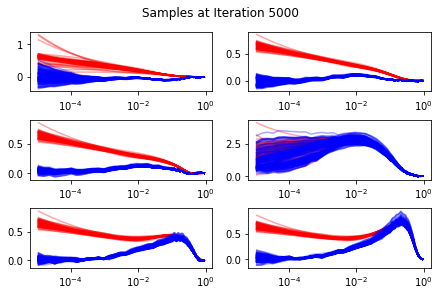

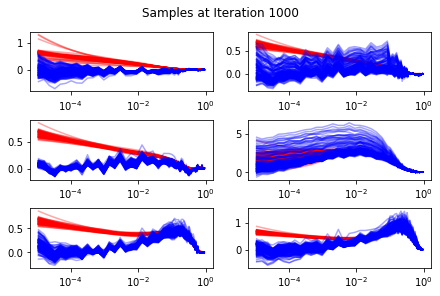

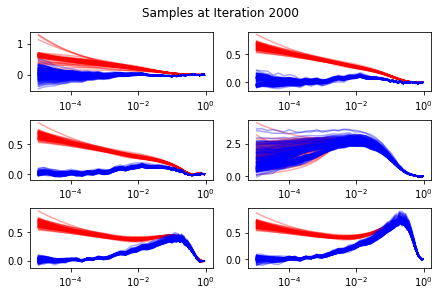

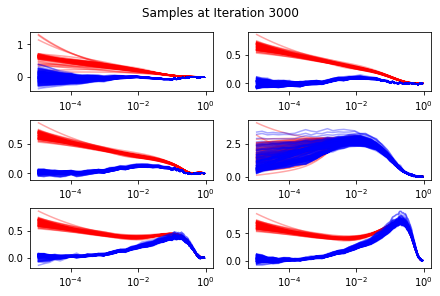

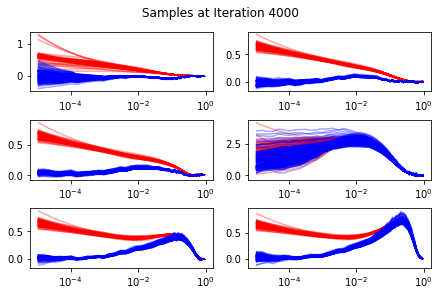

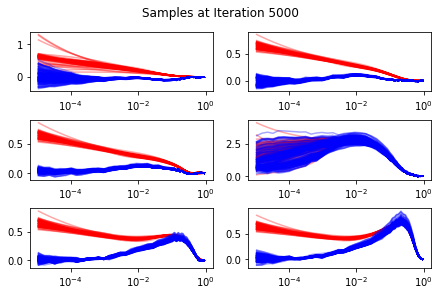

In [13]:
# train model
train(generator, critic, gan_model, pdf, latent_dim, nb_out=2*pdf.shape[0])